In [40]:
%pylab inline

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split

Populating the interactive namespace from numpy and matplotlib


# Import des données

In [2]:
# Remplacer ceci par l'import de vos données
X, y = make_classification(n_samples=10000)

(array([5008.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        4992.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

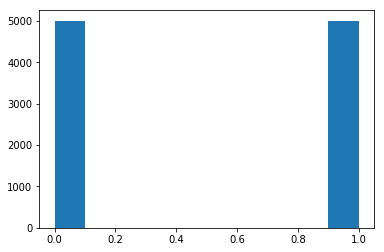

In [43]:
plt.hist(y)

# Division en Train set / Test set

In [4]:
# On utilise un split standard de 75%-25%  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Training

## Premier essai naïf

In [29]:
# On essaie avec un arbre
model = RandomForestClassifier(n_estimators=1)

model.fit(X_train, y_train)
print(f'Training score {accuracy_score(model.predict(X_train), y_train) * 100:.1f}%')

print(f'Test score     {accuracy_score(model.predict(X_test), y_test) * 100:.1f}%')

Training score 95.7%
Test score     87.5%


In [30]:
# On définit une fonction que l'on va réutiliser pour scorer différents modèles

def score_model(model):
    """Réalise la validation croisée d'un modèle sur le training set uniquement
    puis affiche les résultats (moyenne et écart-type de la précision du modèle)"""
    results = cross_val_score(model,
                              X_train,
                              y_train,
                              scoring=make_scorer(accuracy_score),
                              cv=3)
    print(f'Moyenne : {results.mean() * 100:.1f}%, Ecart-Type : {results.std() * 100:.1f}%')

In [31]:
%%time

# On réessaie le même modèle avec la validation croisée
model = RandomForestClassifier(n_estimators=1)
score_model(model)

Moyenne : 88.2%, Ecart-Type : 1.3%
CPU times: user 59.7 ms, sys: 2.44 ms, total: 62.2 ms
Wall time: 61.2 ms


### À quoi ça sert si on peut juste utiliser le test set ?

Et bien ça sert à **VALIDER**, le test set étant idéalement utilisé **UNE SEULE FOIS** une fois que vous aurez choisi le modèle à garder (le modèle *validé*).

Si on teste tous nos essais sur le test set, on a juste choisi le modèle qui fait le meilleur score sur le test set pas le modèle qui fait le meilleur score en général.

Cela peut mener aveuglément à des modèles qui sont **Excellents** sur le papier et **Mauvais** en production...


On utilise donc la validation croisée sur le training set.

## Essais de quelques configurations "à la main"

In [25]:
%%time

# On essaie avec deux arbres
model = RandomForestClassifier(n_estimators=2)
score_model(model)

Moyenne : 87.413%, Ecart-Type : 0.5757%
CPU times: user 91.2 ms, sys: 2.63 ms, total: 93.8 ms
Wall time: 93 ms


In [26]:
%%time

# 10...
model = RandomForestClassifier(n_estimators=10)
score_model(model)

Moyenne : 92.560%, Ecart-Type : 0.3651%
CPU times: user 394 ms, sys: 3.79 ms, total: 398 ms
Wall time: 400 ms


In [28]:
%%time

# 1000...
model = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
score_model(model)

Moyenne : 93.347%, Ecart-Type : 0.2189%
CPU times: user 3.76 s, sys: 483 ms, total: 4.24 s
Wall time: 19.1 s


## Tester plein de combinaisons de manière plus ordonnée

In [33]:
# TODO

# Evaluation Finale

In [34]:
accuracy_score(model.predict(X_test), y_test)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.